# Phase 1 - Convolutional Neural Networks

Please follow the notebook in order. Make sure to add code where indicated by `''' TODO '''` or `# YOUR CODE HERE`. Please answer all questions indicated with '❓', and answer where it says 'ANSWER HERE'.

Ensure your notebook is easy to follow. All written report answers should be provided in the notebook itself.

Section 5 asks you to run different hyperparameters- please make sure to run all your codes and make sure outputs are neat enough to read.

You may find [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) Pytorch tutorial helpful.

## **Overview**
1. Loading & Visualizing Data
2. Utility Functions
3. Define CNNs
4. Train and Evaluate
5. Experiments and Reporting

In [1]:
# Run to import necessary libraries
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np

# **1. Loading & Visualizing Data**

Please use MNIST for this phase. MNIST is a digit classification dataset, with greyscale 28x28 images, and 10 classes (numbers 0-9).

See [documentation.](https://pytorch.org/vision/0.15/generated/torchvision.datasets.MNIST.html) You can also see the `MNIST_Tutorial.ipynb`.

Please complete loading the data below.

Please also complete `show_imgs()`. Function should input the dataloader, and show 10 random images and their labels.

In [2]:
train_data = datasets.MNIST(root = './data', train = True, transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False , transform = transforms.ToTensor())

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 51.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.78MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.77MB/s]


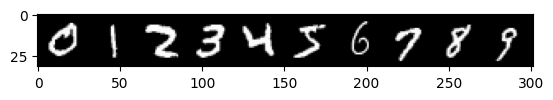

0 1 2 3 4 5 6 7 8 9
Number of images torch.Size([60000, 28, 28])
Number of images torch.Size([10000, 28, 28])


In [8]:
classes = (0,1,2,3,4,5,6,7,8,9)
# Function should input the dataloader, and show random 10 images and their labels as title to plot
def show_imgs(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
num_images = images.size(0)
num_classes = len(classes)

random_indices = []
for class_idx in range(num_classes):
    class_indices = torch.where(labels == class_idx)[0]
    random_idx = torch.randperm(len(class_indices))[:1]
    random_indices.append(class_indices[random_idx])

random_indices = torch.cat(random_indices)
random_images = images[random_indices]
random_labels = labels[random_indices]


# show images
show_imgs(utils.make_grid(random_images, nrow=10))
print(' '.join('%d' % classes[labels[j].item()] for j in random_indices))
print("Number of images", train_data.data.size())
print("Number of images", test_data.data.size())


## **2. Utility Functions**

Please complete `train()` and `plot_learning_curves()` functions. `test_accuracy()` has already been provided to you.

In [ ]:
def test_accuracy(model, test_loader, input_size, device, conv):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
            if conv:
                images = images.view(-1, 1, 28, 28)
            else:
                images = images.view(-1, input_size)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print('Accuracy: %d %%' % (100 * correct / total))
    return (100 * correct / total)


## **2.1 Train Function**
Please refer to the train function in `MNIST_Classifier.ipynb` to complete this function.
- You will need to store the loss and accuracies per iteration (to plot later). Do this for both the train set and test set!
- Please print the loss, accuracy and time taken **each epoch** for both train and test sets

In [ ]:
from time import perf_counter

def train(model, loss_fn, optimizer, train_loader, test_loader, batch_size, num_epochs, device, conv):
    losses = [[], [], []]
    if device is not None:
        model.to(device)
    else:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.to(device)
    for epoch in range(num_epochs):
        start_time = perf_counter()
        tr_loss_average = 0
        for i, data in enumerate(train_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            if conv:
                images = images.view(-1, 1, 28, 28)
            else:
                images = images.view(-1, input_size)
            optimizer.zero_grad()
            outputs = model(images)
            tr_loss = loss_fn(outputs, labels)
            tr_loss_average += tr_loss.item()
            tr_loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                v_loss_average = 0
                count_va = 0
                for _, data in enumerate(test_loader, 0):
                    images, labels = data[0].to(device), data[1].to(device)
                    if conv:
                        images = images.view(-1, 1, 28, 28)
                    else:
                        images = images.view(-1, input_size)
                    outputs = model(images)
                    v_loss_average += loss_fn(outputs, labels).item()
                    count_va += 1

                tr_loss_average /= 100
                v_loss_average /= count_va
                losses[0].append((epoch) * 1875 + (i+1))
                losses[1].append(tr_loss_average)
                losses[2].append(v_loss_average)
                print('Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f, Val Loss: %.4f'
                            %(epoch+1, num_epochs, i+1,
                            len(train_loader), tr_loss_average, v_loss_average))
                tr_loss_average = 0

        stop_time = perf_counter()
        val_acc = test_accuracy(model, test_loader, 784, device, conv)
        train_acc = test_accuracy(model, train_loader, 784, device, conv)
        time = stop_time - start_time
        print('Epoch [%d/%d] End. Duration %.4f seconds. Train Acc: %.4f, Val Acc: %.4f'
                            %(epoch+1, num_epochs, time, train_acc, val_acc))
    return losses

## **2.2 Plot Learning Curves Function**
Plot the loss and accuracies from training. Example outputs will be provided in lab walkthrough.

In [ ]:
def plot_learning_curve(steps, training_loss, validation_loss):
    plt.plot(steps, training_loss, 'r-', label='Training Loss')
    plt.plot(steps, validation_loss, 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# **3. Define CNNs**

A 1-Layer Architecture is already defined for you (`Net`) as a reference. Please complete the definitions of the 2-Layer CNN (`Net2`). The network architecture definitions are provided to you. You must calculate some dimensions yourself.

**NOTE:** For now, please use ReLU activation. You will experiment with other activations in Section 5.

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## **3.1 Create a 2-Layer CNN**
Complete `Net2` class.

 Network Architecture:
* ***Layer 1 (Input)***: Convolutional; input channel = 1, output channel = 20, kernel size = 3, step size = 1.
* ***Layer 2 (Output)***: Fully connected; input dimension = < you find out >, output dimension = < you find out >.

In [ ]:
# Define 2-Layer Network
class Net2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26*20, num_classes)

    def forward(self,x):

        out = self.conv1(x)

        out = self.relu(out)

        out = torch.flatten(out, start_dim=1)

        out = self.fc2(out)

        return out

# **4. Train and Evaluate**

## **4.1 Training and Evaluating 1-Layer CNN**

Here, you must test your utility functions (`train()` and `plot_learning_curves()`)with the 1-Layer Model. Please at this stage ensure your utility functions are working correctly. The TAs will provide sample outputs in lab walkthrough.

**NOTE**: You can repeatedly use this below code block in Section 5 to run experiments, while making changes to the hyperparameters as required.

Epoch [1/10], Step [100/1875], Train Loss: 0.6052, Val Loss: 0.3996
Epoch [1/10], Step [200/1875], Train Loss: 0.3092, Val Loss: 0.4837
Epoch [1/10], Step [300/1875], Train Loss: 0.3697, Val Loss: 0.3049
Epoch [1/10], Step [400/1875], Train Loss: 0.2824, Val Loss: 0.2770
Epoch [1/10], Step [500/1875], Train Loss: 0.3060, Val Loss: 0.2257
Epoch [1/10], Step [600/1875], Train Loss: 0.2504, Val Loss: 0.2399
Epoch [1/10], Step [700/1875], Train Loss: 0.2585, Val Loss: 0.2875
Epoch [1/10], Step [800/1875], Train Loss: 0.2279, Val Loss: 0.2888
Epoch [1/10], Step [900/1875], Train Loss: 0.2554, Val Loss: 0.2203
Epoch [1/10], Step [1000/1875], Train Loss: 0.2466, Val Loss: 0.2334
Epoch [1/10], Step [1100/1875], Train Loss: 0.2151, Val Loss: 0.2203
Epoch [1/10], Step [1200/1875], Train Loss: 0.2400, Val Loss: 0.1978
Epoch [1/10], Step [1300/1875], Train Loss: 0.2153, Val Loss: 0.1976
Epoch [1/10], Step [1400/1875], Train Loss: 0.2090, Val Loss: 0.1917
Epoch [1/10], Step [1500/1875], Train Loss:

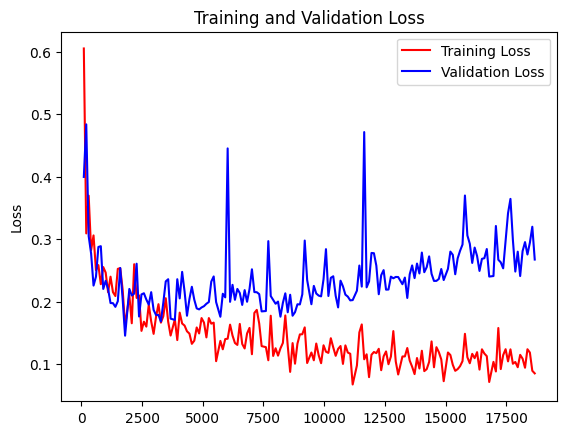

94.99

In [ ]:
# Define Parameters
input_size = 28*28
num_classes = 10
lr = 0.01
num_epochs = 10

# Instantiate 1-Layer Model
net = Net(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
losses = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, False)

# Plot Learning Curves
plot_learning_curve(losses[0], losses[1], losses[2])

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

## **4.2 Training and Evaluating 2-Layer CNN**


Please also train your 2-Layer network to ensure it is working properly.

In [ ]:
# Define Parameters
input_size = 28*28
num_classes = 10
lr = 0.01
num_epochs = 10

# Instantiate 2-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
losses_2 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)

# Plot Learning Curves
plot_learning_curve(losses_2[0], losses_2[1], losses_2[2])

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

Epoch [1/10], Step [100/1875], Train Loss: 0.9538, Val Loss: 0.2604
Epoch [1/10], Step [200/1875], Train Loss: 0.2308, Val Loss: 0.2655
Epoch [1/10], Step [300/1875], Train Loss: 0.2466, Val Loss: 0.2095
Epoch [1/10], Step [400/1875], Train Loss: 0.1503, Val Loss: 0.1707
Epoch [1/10], Step [500/1875], Train Loss: 0.1732, Val Loss: 0.1467
Epoch [1/10], Step [600/1875], Train Loss: 0.1275, Val Loss: 0.1090
Epoch [1/10], Step [700/1875], Train Loss: 0.1311, Val Loss: 0.1426
Epoch [1/10], Step [800/1875], Train Loss: 0.1275, Val Loss: 0.1470
Epoch [1/10], Step [900/1875], Train Loss: 0.1325, Val Loss: 0.1161
Epoch [1/10], Step [1000/1875], Train Loss: 0.1174, Val Loss: 0.1052
Epoch [1/10], Step [1100/1875], Train Loss: 0.1166, Val Loss: 0.1011
Epoch [1/10], Step [1200/1875], Train Loss: 0.1217, Val Loss: 0.1042
Epoch [1/10], Step [1300/1875], Train Loss: 0.1112, Val Loss: 0.0996
Epoch [1/10], Step [1400/1875], Train Loss: 0.1142, Val Loss: 0.0818
Epoch [1/10], Step [1500/1875], Train Loss:

NameError: name 'losses' is not defined

## This code cell was added because I ran all of the above code and had a slight error in the plot_learning_curve function and I don't want to retrain the whole model again just to plot the curve, so I am doing it separately here. The data is still consistent with the above model.

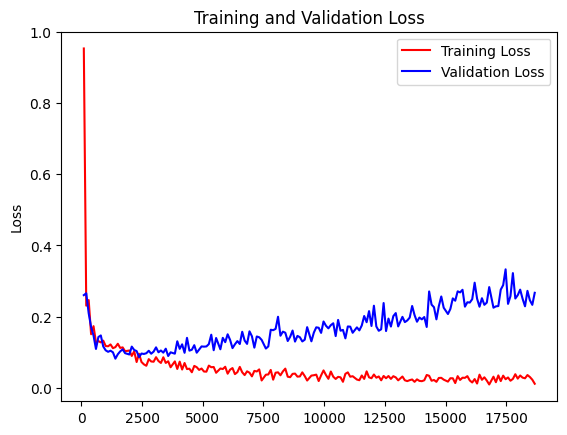

In [ ]:
plot_learning_curve(losses_2[0], losses_2[1], losses_2[2])

# **5. Experiments and Reporting**

In this section, you'll use the utility functions and model definitions from earlier to test various scenarios. You'll modify hyperparameters, run training, plot results, and analyze performance. Based on your observations, you'll answer specific questions.

Use the provided loss, accuracy, and learning curves to address the report questions for each subsection.

**Note:** You will primarily reuse functions from earlier sections. Make any necessary code changes in the sections marked `# YOUR CODE HERE`.

## **5.1 Learning Curves**

### **❓ Q 5.1.1 What is a Learning curve and why is it useful? You can refer to learning curves you have plotted in Section 4.** (you do not need to run any codes here)

A learning curve is a plot of how well your model performs as it trains and validates. It plots training loss and validation loss over steps. They are useful because they can show when your model begins to overfit, as that is where the validation loss begins to increase.

---

### **5.2 Learning Rates**

Please plot the curves for three separate training instances with learning rates of: `2e-3`, `3e-4`, `5e-2 `

Use the 2-Layer CNN.

Epoch [1/10], Step [100/1875], Train Loss: 0.7737, Val Loss: 0.3805
Epoch [1/10], Step [200/1875], Train Loss: 0.3044, Val Loss: 0.3288
Epoch [1/10], Step [300/1875], Train Loss: 0.3272, Val Loss: 0.2855
Epoch [1/10], Step [400/1875], Train Loss: 0.2188, Val Loss: 0.2079
Epoch [1/10], Step [500/1875], Train Loss: 0.2011, Val Loss: 0.1425
Epoch [1/10], Step [600/1875], Train Loss: 0.1411, Val Loss: 0.1275
Epoch [1/10], Step [700/1875], Train Loss: 0.1336, Val Loss: 0.1449
Epoch [1/10], Step [800/1875], Train Loss: 0.1276, Val Loss: 0.1219
Epoch [1/10], Step [900/1875], Train Loss: 0.1277, Val Loss: 0.1088
Epoch [1/10], Step [1000/1875], Train Loss: 0.1274, Val Loss: 0.1065
Epoch [1/10], Step [1100/1875], Train Loss: 0.1055, Val Loss: 0.1009
Epoch [1/10], Step [1200/1875], Train Loss: 0.1262, Val Loss: 0.1031
Epoch [1/10], Step [1300/1875], Train Loss: 0.1049, Val Loss: 0.0919
Epoch [1/10], Step [1400/1875], Train Loss: 0.1036, Val Loss: 0.0934
Epoch [1/10], Step [1500/1875], Train Loss:

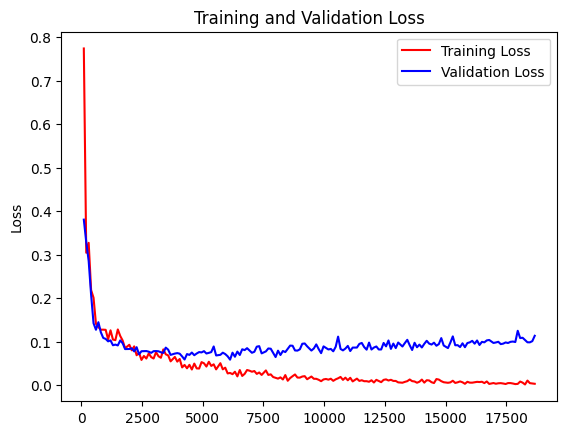

In [ ]:
# 2e-3
input_size = 28*28
num_classes = 10
lr = 0.002
num_epochs = 10

net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_3 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)
plot_learning_curve(losses_3[0], losses_3[1], losses_3[2])

Epoch [1/10], Step [100/1875], Train Loss: 1.2531, Val Loss: 0.6494
Epoch [1/10], Step [200/1875], Train Loss: 0.4637, Val Loss: 0.4093
Epoch [1/10], Step [300/1875], Train Loss: 0.4282, Val Loss: 0.3603
Epoch [1/10], Step [400/1875], Train Loss: 0.3507, Val Loss: 0.3617
Epoch [1/10], Step [500/1875], Train Loss: 0.3766, Val Loss: 0.2883
Epoch [1/10], Step [600/1875], Train Loss: 0.2855, Val Loss: 0.2588
Epoch [1/10], Step [700/1875], Train Loss: 0.2624, Val Loss: 0.2537
Epoch [1/10], Step [800/1875], Train Loss: 0.2644, Val Loss: 0.2487
Epoch [1/10], Step [900/1875], Train Loss: 0.2558, Val Loss: 0.2382
Epoch [1/10], Step [1000/1875], Train Loss: 0.2780, Val Loss: 0.2304
Epoch [1/10], Step [1100/1875], Train Loss: 0.2271, Val Loss: 0.2138
Epoch [1/10], Step [1200/1875], Train Loss: 0.2451, Val Loss: 0.2209
Epoch [1/10], Step [1300/1875], Train Loss: 0.2166, Val Loss: 0.2120
Epoch [1/10], Step [1400/1875], Train Loss: 0.2174, Val Loss: 0.1937
Epoch [1/10], Step [1500/1875], Train Loss:

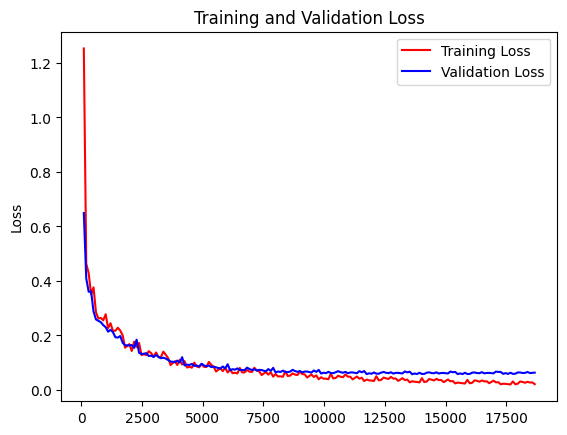

In [ ]:
# 3e-4
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10

net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_4 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)
plot_learning_curve(losses_4[0], losses_4[1], losses_4[2])

Epoch [1/10], Step [100/1875], Train Loss: 2.2320, Val Loss: 0.3579
Epoch [1/10], Step [200/1875], Train Loss: 0.3000, Val Loss: 0.3711
Epoch [1/10], Step [300/1875], Train Loss: 0.3587, Val Loss: 0.2612
Epoch [1/10], Step [400/1875], Train Loss: 0.2580, Val Loss: 0.2673
Epoch [1/10], Step [500/1875], Train Loss: 0.2790, Val Loss: 0.3061
Epoch [1/10], Step [600/1875], Train Loss: 0.2368, Val Loss: 0.1901
Epoch [1/10], Step [700/1875], Train Loss: 0.2578, Val Loss: 0.2760
Epoch [1/10], Step [800/1875], Train Loss: 0.4735, Val Loss: 0.3405
Epoch [1/10], Step [900/1875], Train Loss: 0.3860, Val Loss: 0.2977
Epoch [1/10], Step [1000/1875], Train Loss: 0.3757, Val Loss: 0.3045
Epoch [1/10], Step [1100/1875], Train Loss: 0.2731, Val Loss: 0.2542
Epoch [1/10], Step [1200/1875], Train Loss: 0.3359, Val Loss: 0.3742
Epoch [1/10], Step [1300/1875], Train Loss: 0.3119, Val Loss: 0.2793
Epoch [1/10], Step [1400/1875], Train Loss: 0.3199, Val Loss: 0.2674
Epoch [1/10], Step [1500/1875], Train Loss:

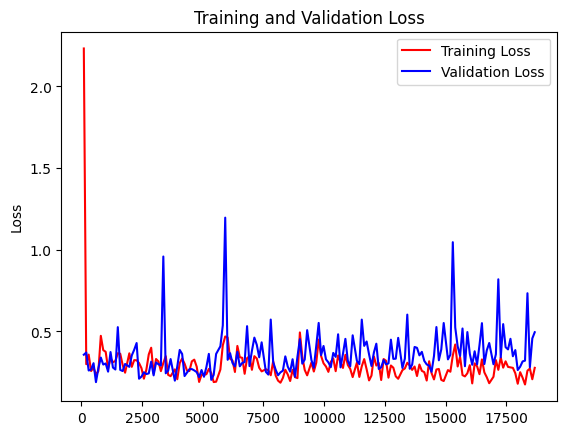

In [ ]:
# 5e-2
input_size = 28*28
num_classes = 10
lr = 0.05
num_epochs = 10

net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_5 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)
plot_learning_curve(losses_5[0], losses_5[1], losses_5[2])

### ❓ **Q 5.2.1 For each learning rate, explain if the model is underfitting, overfitting, or is training well. Explain the difference between high learning rates and low learning rates in terms of the optimization process.**

For the learning rate of 2e-3, it is observed that the model will begin to overfit after some time of training, since smaller learning rates mean that local minima specific to the training set would be picked up by the model and thus overfit to the training dataset. With the learning rate of 3e-4, it is observed that the model trains well as the loss between the validation and training data are relatively similar to each other throughout the training, so the learning rate is generalizeable to the testing dataset. As for the learning rate of 5e-2, it is seen that the loss is very volatile, since making the learning rate higher makes finding the minima point of the loss function nearly impossible as it overshoots frequently and jumps around the minimal point.

---

### **5.3 Optimizer**
The optimizer we have used before is Adam. Change the optimizer to:
- **Stochastic gradient descent ([SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html))**
- **SGD with momentum:** try momentum 0.5 and 0.9.

Use 2-Layer CNN. Keep all other hyperparameters constant. You can use the best from earlier experiments.

Epoch [1/10], Step [100/1875], Train Loss: 2.2739, Val Loss: 2.2360
Epoch [1/10], Step [200/1875], Train Loss: 2.1941, Val Loss: 2.1633
Epoch [1/10], Step [300/1875], Train Loss: 2.1364, Val Loss: 2.0965
Epoch [1/10], Step [400/1875], Train Loss: 2.0582, Val Loss: 2.0269
Epoch [1/10], Step [500/1875], Train Loss: 2.0105, Val Loss: 1.9617
Epoch [1/10], Step [600/1875], Train Loss: 1.9476, Val Loss: 1.8951
Epoch [1/10], Step [700/1875], Train Loss: 1.8549, Val Loss: 1.8235
Epoch [1/10], Step [800/1875], Train Loss: 1.7973, Val Loss: 1.7535
Epoch [1/10], Step [900/1875], Train Loss: 1.7232, Val Loss: 1.6822
Epoch [1/10], Step [1000/1875], Train Loss: 1.7001, Val Loss: 1.6162
Epoch [1/10], Step [1100/1875], Train Loss: 1.6112, Val Loss: 1.5477
Epoch [1/10], Step [1200/1875], Train Loss: 1.5343, Val Loss: 1.4799
Epoch [1/10], Step [1300/1875], Train Loss: 1.4679, Val Loss: 1.4138
Epoch [1/10], Step [1400/1875], Train Loss: 1.4142, Val Loss: 1.3498
Epoch [1/10], Step [1500/1875], Train Loss:

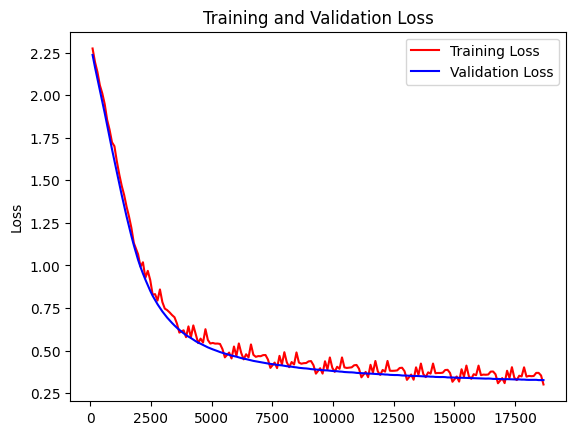

In [ ]:
# SGD
# 3e-4
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10

net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
losses_6 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)
plot_learning_curve(losses_6[0], losses_6[1], losses_6[2])

Epoch [1/10], Step [100/1875], Train Loss: 2.2419, Val Loss: 2.1778
Epoch [1/10], Step [200/1875], Train Loss: 2.1065, Val Loss: 2.0494
Epoch [1/10], Step [300/1875], Train Loss: 1.9957, Val Loss: 1.9261
Epoch [1/10], Step [400/1875], Train Loss: 1.8500, Val Loss: 1.7923
Epoch [1/10], Step [500/1875], Train Loss: 1.7586, Val Loss: 1.6624
Epoch [1/10], Step [600/1875], Train Loss: 1.6304, Val Loss: 1.5281
Epoch [1/10], Step [700/1875], Train Loss: 1.4493, Val Loss: 1.3916
Epoch [1/10], Step [800/1875], Train Loss: 1.3423, Val Loss: 1.2667
Epoch [1/10], Step [900/1875], Train Loss: 1.2169, Val Loss: 1.1517
Epoch [1/10], Step [1000/1875], Train Loss: 1.1888, Val Loss: 1.0555
Epoch [1/10], Step [1100/1875], Train Loss: 1.0542, Val Loss: 0.9683
Epoch [1/10], Step [1200/1875], Train Loss: 0.9556, Val Loss: 0.8940
Epoch [1/10], Step [1300/1875], Train Loss: 0.8992, Val Loss: 0.8316
Epoch [1/10], Step [1400/1875], Train Loss: 0.8460, Val Loss: 0.7783
Epoch [1/10], Step [1500/1875], Train Loss:

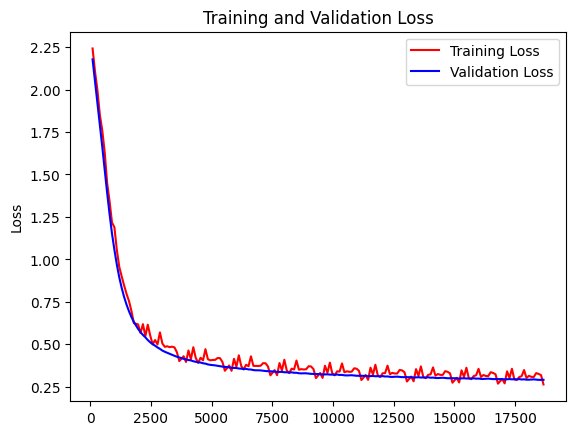

In [ ]:
# SGD 0.5
# SGD
# 3e-4
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10

net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.5)
losses_7 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)
plot_learning_curve(losses_7[0], losses_7[1], losses_7[2])

Epoch [1/10], Step [100/1875], Train Loss: 1.8264, Val Loss: 1.3410
Epoch [1/10], Step [200/1875], Train Loss: 1.0238, Val Loss: 0.8241
Epoch [1/10], Step [300/1875], Train Loss: 0.7629, Val Loss: 0.6284
Epoch [1/10], Step [400/1875], Train Loss: 0.5762, Val Loss: 0.5350
Epoch [1/10], Step [500/1875], Train Loss: 0.5888, Val Loss: 0.4727
Epoch [1/10], Step [600/1875], Train Loss: 0.4835, Val Loss: 0.4333
Epoch [1/10], Step [700/1875], Train Loss: 0.4217, Val Loss: 0.4125
Epoch [1/10], Step [800/1875], Train Loss: 0.4369, Val Loss: 0.4014
Epoch [1/10], Step [900/1875], Train Loss: 0.4060, Val Loss: 0.3832
Epoch [1/10], Step [1000/1875], Train Loss: 0.4625, Val Loss: 0.3701
Epoch [1/10], Step [1100/1875], Train Loss: 0.3931, Val Loss: 0.3608
Epoch [1/10], Step [1200/1875], Train Loss: 0.3901, Val Loss: 0.3563
Epoch [1/10], Step [1300/1875], Train Loss: 0.3829, Val Loss: 0.3530
Epoch [1/10], Step [1400/1875], Train Loss: 0.3841, Val Loss: 0.3415
Epoch [1/10], Step [1500/1875], Train Loss:

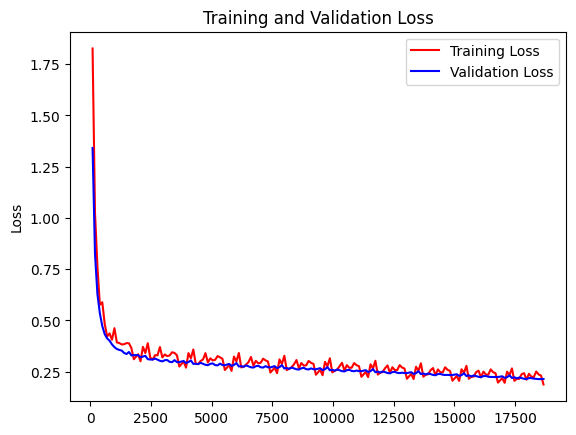

In [ ]:
# SGD 0.9
# SGD
# 3e-4
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10

net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
losses_8 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)
plot_learning_curve(losses_8[0], losses_8[1], losses_8[2])

#### ❓ **Q 5.3.1 Explain the differences in Adam and both SGD optimizations. Compare the results of each optimizer based on the learning curves.**

The Adam optimizer is converging upon the minimum loss faster than the SGD optimizer, which feeds the CNN with a packet of data to adjust the NN's weights. As such, there are more fluctutations in the SGD optimizations than there are in the Adam optimizer. SGD with momentum involved is used to combat against getting stuck in non-global minima of the loss function. As such, the momentum based optimizers are more accurate than the non-momentum based optimizer.

---

### **5.4 Initializing Weights**

Initialize the weights to:
- all zeros
- all ones
- all randomly initialized with a normal distribution.

Use 2-Layer CNN.

Epoch [1/10], Step [100/1875], Train Loss: 2.3025, Val Loss: 2.3024
Epoch [1/10], Step [200/1875], Train Loss: 2.3022, Val Loss: 2.3022
Epoch [1/10], Step [300/1875], Train Loss: 2.3021, Val Loss: 2.3021
Epoch [1/10], Step [400/1875], Train Loss: 2.3020, Val Loss: 2.3020
Epoch [1/10], Step [500/1875], Train Loss: 2.3019, Val Loss: 2.3019
Epoch [1/10], Step [600/1875], Train Loss: 2.3014, Val Loss: 2.3017
Epoch [1/10], Step [700/1875], Train Loss: 2.3019, Val Loss: 2.3016
Epoch [1/10], Step [800/1875], Train Loss: 2.3017, Val Loss: 2.3016
Epoch [1/10], Step [900/1875], Train Loss: 2.3018, Val Loss: 2.3015
Epoch [1/10], Step [1000/1875], Train Loss: 2.3014, Val Loss: 2.3015
Epoch [1/10], Step [1100/1875], Train Loss: 2.3016, Val Loss: 2.3014
Epoch [1/10], Step [1200/1875], Train Loss: 2.3019, Val Loss: 2.3014
Epoch [1/10], Step [1300/1875], Train Loss: 2.3013, Val Loss: 2.3013
Epoch [1/10], Step [1400/1875], Train Loss: 2.3011, Val Loss: 2.3013
Epoch [1/10], Step [1500/1875], Train Loss:

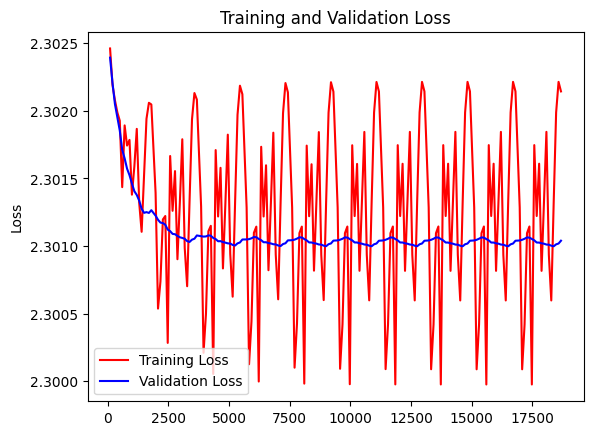

In [ ]:
# All zeros
# Adam
# 3e-4
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10

net = Net2(input_size, num_classes)
for param in net.parameters():
    nn.init.constant_(param, 0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_9 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)
plot_learning_curve(losses_9[0], losses_9[1], losses_9[2])

Epoch [1/10], Step [100/1875], Train Loss: 1.2627, Val Loss: 0.6038
Epoch [1/10], Step [200/1875], Train Loss: 0.7216, Val Loss: 1.0590
Epoch [1/10], Step [300/1875], Train Loss: 0.9081, Val Loss: 1.2488
Epoch [1/10], Step [400/1875], Train Loss: 0.9525, Val Loss: 1.1249
Epoch [1/10], Step [500/1875], Train Loss: 1.0098, Val Loss: 0.7350
Epoch [1/10], Step [600/1875], Train Loss: 0.8419, Val Loss: 1.0929
Epoch [1/10], Step [700/1875], Train Loss: 0.9345, Val Loss: 0.9288
Epoch [1/10], Step [800/1875], Train Loss: 0.8514, Val Loss: 0.8841
Epoch [1/10], Step [900/1875], Train Loss: 0.8679, Val Loss: 0.9760
Epoch [1/10], Step [1000/1875], Train Loss: 0.8920, Val Loss: 0.7585
Epoch [1/10], Step [1100/1875], Train Loss: 0.8514, Val Loss: 0.8274
Epoch [1/10], Step [1200/1875], Train Loss: 0.9494, Val Loss: 0.8176
Epoch [1/10], Step [1300/1875], Train Loss: 0.8928, Val Loss: 0.7540
Epoch [1/10], Step [1400/1875], Train Loss: 0.8561, Val Loss: 0.8268
Epoch [1/10], Step [1500/1875], Train Loss:

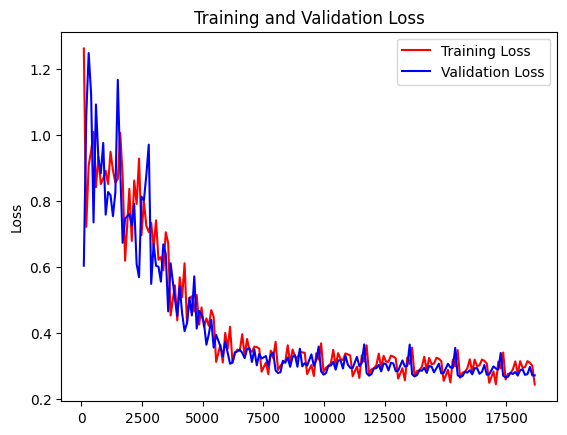

In [ ]:
# All ones
# Adam
# 3e-4
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10

net = Net2(input_size, num_classes)
for param in net.parameters():
    nn.init.constant_(param, 1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_10 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)
plot_learning_curve(losses_10[0], losses_10[1], losses_10[2])

Epoch [1/10], Step [100/1875], Train Loss: 1.5614, Val Loss: 0.6932
Epoch [1/10], Step [200/1875], Train Loss: 0.4918, Val Loss: 0.4243
Epoch [1/10], Step [300/1875], Train Loss: 0.4498, Val Loss: 0.3819
Epoch [1/10], Step [400/1875], Train Loss: 0.3772, Val Loss: 0.3873
Epoch [1/10], Step [500/1875], Train Loss: 0.4247, Val Loss: 0.3252
Epoch [1/10], Step [600/1875], Train Loss: 0.3328, Val Loss: 0.3065
Epoch [1/10], Step [700/1875], Train Loss: 0.3089, Val Loss: 0.3036
Epoch [1/10], Step [800/1875], Train Loss: 0.3244, Val Loss: 0.3060
Epoch [1/10], Step [900/1875], Train Loss: 0.3173, Val Loss: 0.2970
Epoch [1/10], Step [1000/1875], Train Loss: 0.3483, Val Loss: 0.2929
Epoch [1/10], Step [1100/1875], Train Loss: 0.2945, Val Loss: 0.2798
Epoch [1/10], Step [1200/1875], Train Loss: 0.3198, Val Loss: 0.2915
Epoch [1/10], Step [1300/1875], Train Loss: 0.2991, Val Loss: 0.2875
Epoch [1/10], Step [1400/1875], Train Loss: 0.2999, Val Loss: 0.2672
Epoch [1/10], Step [1500/1875], Train Loss:

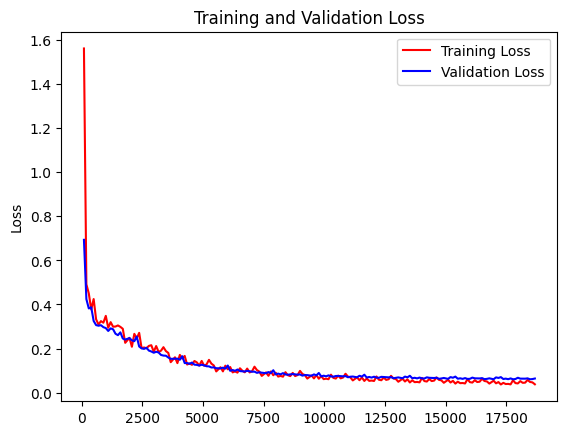

In [ ]:
# Random
# Adam
# 3e-4
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10

net = Net2(input_size, num_classes)
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_11 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)
plot_learning_curve(losses_11[0], losses_11[1], losses_11[2])

#### ❓ **Q 5.4.1 How is the training process affected when we initialize our network weights differently? Based on what you observe, give a recommendation as to how weights should be initialized. Explain your reasoning.**

(Note: your results may not reflect what is expected. Please explain what is expected and why your results may not reflect that.)

When the initial weights are set to 0, it is seen that the loss of both the training data and the validation data are both really high. This can be explained because when the model updates the weights of the network, it would run in to the problem of multiplying a weight of 0, so the network would not be learning from each input forward propogation.

When the weights are initially 1, it's seen that initially, the fluctutations are volatile, but gradually fluctuations begin to constrain and converge upon a lower loss. This can be explained because of the idea that the weights would be very influenced by the first weight update, as such the training loss would decrease, but the validation loss would spike up. As more and more batches are fed to the network, the model will continue to learn and the training loss and validation loss will minimize together as the weights of the network approaches the correct weights.

When the weights are initialized to random numbers, there are less flucatation in the losses and seems to smoothly converge onto a stable loss after a shorter amount of time training. This can be explained because there is a sense of randomness at which where we start that would allow us to find the optimal solution much faster. When we set the weights to be the same initially as in the previous two examples, it led to the model passing inputs that were the exact same value to each and every node in the hidden layer. This caused symmetry in the model, which is not favorable and therefore must be broken via random weight initialization.

---

### **5.5 Activation Function**

Please change the `relu` function in the example code to a `tanh` function.

Use 2-Layer CNN. Keep all other hyperparameters constant. You can use the best from earlier experiments.

Epoch [1/10], Step [100/1875], Train Loss: 1.0541, Val Loss: 0.5804
Epoch [1/10], Step [200/1875], Train Loss: 0.4445, Val Loss: 0.4289
Epoch [1/10], Step [300/1875], Train Loss: 0.4563, Val Loss: 0.3926
Epoch [1/10], Step [400/1875], Train Loss: 0.3843, Val Loss: 0.3959
Epoch [1/10], Step [500/1875], Train Loss: 0.4245, Val Loss: 0.3293
Epoch [1/10], Step [600/1875], Train Loss: 0.3357, Val Loss: 0.3099
Epoch [1/10], Step [700/1875], Train Loss: 0.3208, Val Loss: 0.3075
Epoch [1/10], Step [800/1875], Train Loss: 0.3354, Val Loss: 0.3153
Epoch [1/10], Step [900/1875], Train Loss: 0.3253, Val Loss: 0.3130
Epoch [1/10], Step [1000/1875], Train Loss: 0.3765, Val Loss: 0.3206
Epoch [1/10], Step [1100/1875], Train Loss: 0.3130, Val Loss: 0.2983
Epoch [1/10], Step [1200/1875], Train Loss: 0.3424, Val Loss: 0.3189
Epoch [1/10], Step [1300/1875], Train Loss: 0.3232, Val Loss: 0.3210
Epoch [1/10], Step [1400/1875], Train Loss: 0.3273, Val Loss: 0.2925
Epoch [1/10], Step [1500/1875], Train Loss:

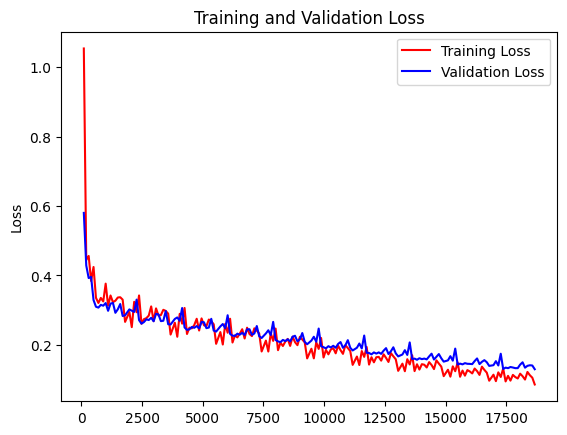

In [ ]:
# Define 2-Layer Network
class Net2Tanh(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2Tanh,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(26*26*20, num_classes)

    def forward(self,x):
        out = self.conv1(x)
        out = self.tanh(out)
        out = torch.flatten(out, start_dim=1)
        out = self.fc2(out)
        return out

# 3e-4
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10

net = Net2Tanh(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_12 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)
plot_learning_curve(losses_12[0], losses_12[1], losses_12[2])

#### ❓ **Q 5.5.1 How does changing the activation function to tanh affect the performance? Is it better or worse? Explain why.**

The ReLU had a better performance in terms of both training and validation accuracy. This may be because ReLu is more resilient of a method because of its simplicity. It therefore would avoid the problem of vanishing gradients.

---

### **5.6 Batch Size**

Test training using different batch sizes to compare. Please use batch size of:
- 8
- 64
- 128

Use 2-Layer CNN. Keep all other hyperparameters constant. You can use the best from earlier experiments.

Epoch [1/10], Step [100/1875], Train Loss: 0.9113, Val Loss: 0.5123
Epoch [1/10], Step [200/1875], Train Loss: 0.4059, Val Loss: 0.4134
Epoch [1/10], Step [300/1875], Train Loss: 0.4437, Val Loss: 0.3837
Epoch [1/10], Step [400/1875], Train Loss: 0.3770, Val Loss: 0.3803
Epoch [1/10], Step [500/1875], Train Loss: 0.4165, Val Loss: 0.3200
Epoch [1/10], Step [600/1875], Train Loss: 0.3288, Val Loss: 0.3065
Epoch [1/10], Step [700/1875], Train Loss: 0.3205, Val Loss: 0.3036
Epoch [1/10], Step [800/1875], Train Loss: 0.3341, Val Loss: 0.3158
Epoch [1/10], Step [900/1875], Train Loss: 0.3223, Val Loss: 0.3120
Epoch [1/10], Step [1000/1875], Train Loss: 0.3776, Val Loss: 0.3222
Epoch [1/10], Step [1100/1875], Train Loss: 0.3126, Val Loss: 0.2981
Epoch [1/10], Step [1200/1875], Train Loss: 0.3423, Val Loss: 0.3168
Epoch [1/10], Step [1300/1875], Train Loss: 0.3223, Val Loss: 0.3262
Epoch [1/10], Step [1400/1875], Train Loss: 0.3256, Val Loss: 0.2907
Epoch [1/10], Step [1500/1875], Train Loss:

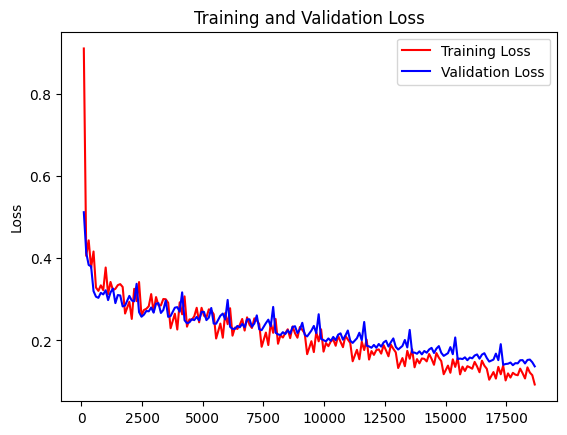

In [ ]:
# Batch size 8
# 3e-4
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10

net = Net2Tanh(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_13 = train(net, loss_function, optimizer, train_loader, test_loader, 8, num_epochs, device, True)
plot_learning_curve(losses_13[0], losses_13[1], losses_13[2])

Epoch [1/10], Step [100/1875], Train Loss: 1.1231, Val Loss: 0.6245
Epoch [1/10], Step [200/1875], Train Loss: 0.4823, Val Loss: 0.4500
Epoch [1/10], Step [300/1875], Train Loss: 0.4783, Val Loss: 0.3937
Epoch [1/10], Step [400/1875], Train Loss: 0.3904, Val Loss: 0.3874
Epoch [1/10], Step [500/1875], Train Loss: 0.4302, Val Loss: 0.3306
Epoch [1/10], Step [600/1875], Train Loss: 0.3435, Val Loss: 0.3205
Epoch [1/10], Step [700/1875], Train Loss: 0.3290, Val Loss: 0.3153
Epoch [1/10], Step [800/1875], Train Loss: 0.3468, Val Loss: 0.3278
Epoch [1/10], Step [900/1875], Train Loss: 0.3279, Val Loss: 0.3185
Epoch [1/10], Step [1000/1875], Train Loss: 0.3892, Val Loss: 0.3306
Epoch [1/10], Step [1100/1875], Train Loss: 0.3176, Val Loss: 0.3035
Epoch [1/10], Step [1200/1875], Train Loss: 0.3444, Val Loss: 0.3207
Epoch [1/10], Step [1300/1875], Train Loss: 0.3260, Val Loss: 0.3336
Epoch [1/10], Step [1400/1875], Train Loss: 0.3296, Val Loss: 0.2946
Epoch [1/10], Step [1500/1875], Train Loss:

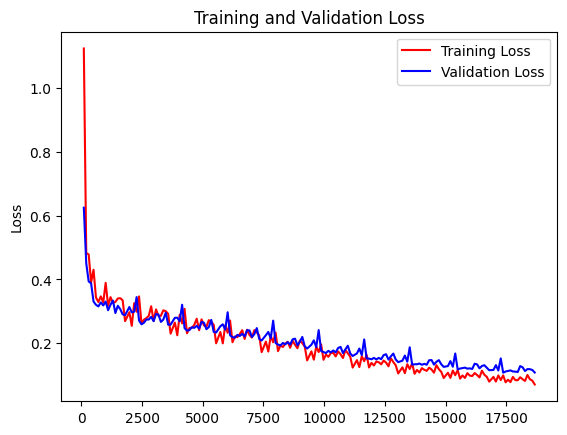

In [ ]:
# Batch size 64
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10

net = Net2Tanh(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_14 = train(net, loss_function, optimizer, train_loader, test_loader, 64, num_epochs, device, True)
plot_learning_curve(losses_14[0], losses_14[1], losses_14[2])

Epoch [1/10], Step [100/1875], Train Loss: 0.9552, Val Loss: 0.5262
Epoch [1/10], Step [200/1875], Train Loss: 0.4139, Val Loss: 0.4164
Epoch [1/10], Step [300/1875], Train Loss: 0.4510, Val Loss: 0.3840
Epoch [1/10], Step [400/1875], Train Loss: 0.3807, Val Loss: 0.3815
Epoch [1/10], Step [500/1875], Train Loss: 0.4210, Val Loss: 0.3224
Epoch [1/10], Step [600/1875], Train Loss: 0.3359, Val Loss: 0.3124
Epoch [1/10], Step [700/1875], Train Loss: 0.3260, Val Loss: 0.3084
Epoch [1/10], Step [800/1875], Train Loss: 0.3398, Val Loss: 0.3213
Epoch [1/10], Step [900/1875], Train Loss: 0.3276, Val Loss: 0.3194
Epoch [1/10], Step [1000/1875], Train Loss: 0.3835, Val Loss: 0.3292
Epoch [1/10], Step [1100/1875], Train Loss: 0.3185, Val Loss: 0.3024
Epoch [1/10], Step [1200/1875], Train Loss: 0.3475, Val Loss: 0.3230
Epoch [1/10], Step [1300/1875], Train Loss: 0.3293, Val Loss: 0.3312
Epoch [1/10], Step [1400/1875], Train Loss: 0.3317, Val Loss: 0.2957
Epoch [1/10], Step [1500/1875], Train Loss:

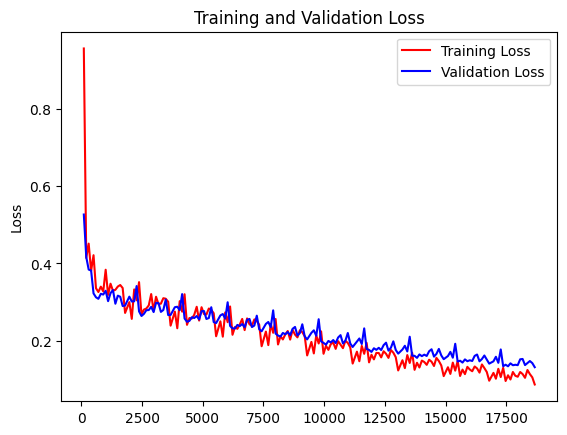

In [ ]:
# Batch size 128
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10

net = Net2Tanh(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_15 = train(net, loss_function, optimizer, train_loader, test_loader, 128, num_epochs, device, True)
plot_learning_curve(losses_15[0], losses_15[1], losses_15[2])

#### ❓ **Q 5.6.1 How does changing batch size affect the training process?**

Changing the batch_size affects the training by increasing the accuracy of the model, but begins to drop in performance once batch size exceeds a size of 64.

---

### 5.7 Different Network Architectures

Please complete the `Net5` and `FCN` definitions. The archtiectures are defined below.


#### **5.7.1 Net5: 5-Layer CNN**
Similar to the 2-Layer model, make a new class ```Net5```.

* ***Layer 1 (Input)***: Convolutional, input channel = 1, output channel = 32, kernel size = 5, stride = 1, padding = 2.
* ***Layer 2 (Hidden 1)***: Pooling, kernel size = 2, stride = 2.
* ***Layer 3 (Hidden 2)***: Convolutional, input channel = < you find out> , output channel = 64, kernel size = 5, stride = 1 padding = 2.
* ***Layer 4 (Hidden 3)***: Fully connected, input channel = < you find out>, output channel = 1024.
* ***Layer 5 (Output)***: Fully connected, input channel = < you find out>, < you find out >

In [ ]:
# YOUR CODE HERE (NET5)

# ...

# Define 5-Layer Network
class Net5(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net5,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2, stride = 1)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding = 2)
        self.fc1 = nn.Linear(14*14*64, 1024)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self,x):
        out = self.conv1(x)
        out = self.pooling(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = torch.flatten(out, start_dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ...

#### **5.7.2 FCN**

Here we will define a Fully Connected Network `FCN` (Not a CNN).

- **Layer 1 (Input):** Size = < you find out >
- **Layer 2 (Hidden 1):** 256 neurons
- **Layer 3 (Hidden 2):** 256 neurons
- **Layer 4 (Output):** Size = < you find out >

In [ ]:
# YOUR CODE HERE (FCN)

# ...

# Define FCN
class FCN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FCN,self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# ...

#### **5.7.3 Training the different architectures**

Train and evaluate `Net2`, `Net5`, and `FCN` using batch size of 64, the best learning rate from Section 5.1, and the best optimizer from Section 5.5


Epoch [1/10], Step [100/1875], Train Loss: 1.5264, Val Loss: 0.6734
Epoch [1/10], Step [200/1875], Train Loss: 0.4841, Val Loss: 0.4215
Epoch [1/10], Step [300/1875], Train Loss: 0.4472, Val Loss: 0.3784
Epoch [1/10], Step [400/1875], Train Loss: 0.3741, Val Loss: 0.3822
Epoch [1/10], Step [500/1875], Train Loss: 0.4188, Val Loss: 0.3212
Epoch [1/10], Step [600/1875], Train Loss: 0.3284, Val Loss: 0.3016
Epoch [1/10], Step [700/1875], Train Loss: 0.3038, Val Loss: 0.2985
Epoch [1/10], Step [800/1875], Train Loss: 0.3181, Val Loss: 0.2987
Epoch [1/10], Step [900/1875], Train Loss: 0.3109, Val Loss: 0.2890
Epoch [1/10], Step [1000/1875], Train Loss: 0.3392, Val Loss: 0.2845
Epoch [1/10], Step [1100/1875], Train Loss: 0.2858, Val Loss: 0.2701
Epoch [1/10], Step [1200/1875], Train Loss: 0.3097, Val Loss: 0.2818
Epoch [1/10], Step [1300/1875], Train Loss: 0.2887, Val Loss: 0.2763
Epoch [1/10], Step [1400/1875], Train Loss: 0.2858, Val Loss: 0.2575
Epoch [1/10], Step [1500/1875], Train Loss:

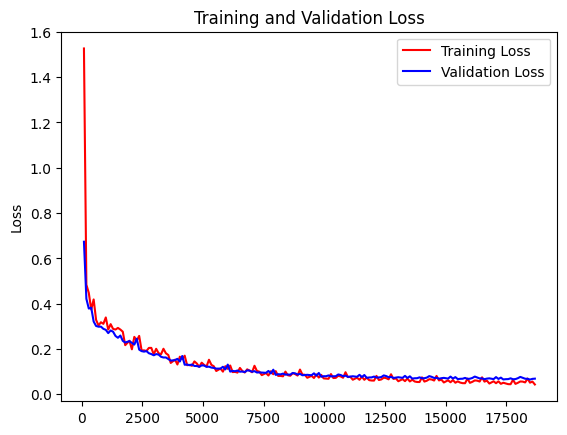

In [ ]:
# Net2

input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10
batch_size = 64
net = Net2(input_size, num_classes)
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_net2 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)
plot_learning_curve(losses_net2[0], losses_net2[1], losses_net2[2])




In [ ]:
# Net5
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10
batch_size = 64
net = Net5(input_size, num_classes)
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_net5 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)

Epoch [1/10], Step [100/1875], Train Loss: 1.0045, Val Loss: 0.4489
Epoch [1/10], Step [200/1875], Train Loss: 0.3495, Val Loss: 0.3342
Epoch [1/10], Step [300/1875], Train Loss: 0.3318, Val Loss: 0.2732
Epoch [1/10], Step [400/1875], Train Loss: 0.2339, Val Loss: 0.2279
Epoch [1/10], Step [500/1875], Train Loss: 0.2068, Val Loss: 0.1829
Epoch [1/10], Step [600/1875], Train Loss: 0.1509, Val Loss: 0.1268
Epoch [1/10], Step [700/1875], Train Loss: 0.1368, Val Loss: 0.1383
Epoch [1/10], Step [800/1875], Train Loss: 0.1342, Val Loss: 0.1090
Epoch [1/10], Step [900/1875], Train Loss: 0.1325, Val Loss: 0.1176
Epoch [1/10], Step [1000/1875], Train Loss: 0.1203, Val Loss: 0.0948
Epoch [1/10], Step [1100/1875], Train Loss: 0.1091, Val Loss: 0.0980
Epoch [1/10], Step [1200/1875], Train Loss: 0.1187, Val Loss: 0.1069
Epoch [1/10], Step [1300/1875], Train Loss: 0.1021, Val Loss: 0.0930
Epoch [1/10], Step [1400/1875], Train Loss: 0.0907, Val Loss: 0.0786
Epoch [1/10], Step [1500/1875], Train Loss:

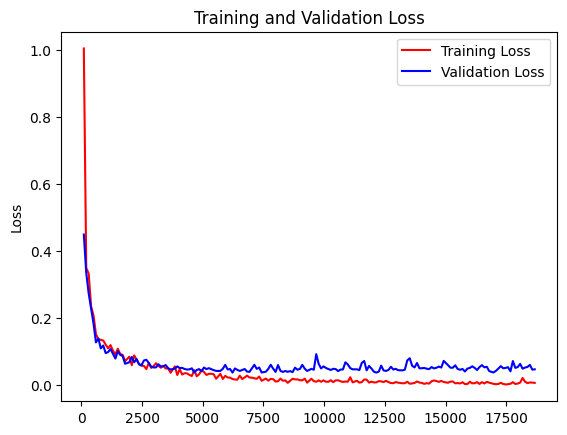

In [ ]:
plot_learning_curve(losses_net5[0], losses_net5[1], losses_net5[2])

In [ ]:
# FCN
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10
batch_size = 64
net = FCN(input_size, num_classes)
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_FCN = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, False)


Epoch [1/10], Step [100/1875], Train Loss: 1.6903, Val Loss: 0.9032
Epoch [1/10], Step [200/1875], Train Loss: 0.6980, Val Loss: 0.6350
Epoch [1/10], Step [300/1875], Train Loss: 0.6177, Val Loss: 0.5171
Epoch [1/10], Step [400/1875], Train Loss: 0.4782, Val Loss: 0.4679
Epoch [1/10], Step [500/1875], Train Loss: 0.4790, Val Loss: 0.3828
Epoch [1/10], Step [600/1875], Train Loss: 0.4034, Val Loss: 0.3542
Epoch [1/10], Step [700/1875], Train Loss: 0.3643, Val Loss: 0.3605
Epoch [1/10], Step [800/1875], Train Loss: 0.3650, Val Loss: 0.3271
Epoch [1/10], Step [900/1875], Train Loss: 0.3513, Val Loss: 0.3293
Epoch [1/10], Step [1000/1875], Train Loss: 0.3781, Val Loss: 0.3084
Epoch [1/10], Step [1100/1875], Train Loss: 0.3120, Val Loss: 0.3021
Epoch [1/10], Step [1200/1875], Train Loss: 0.3260, Val Loss: 0.3209
Epoch [1/10], Step [1300/1875], Train Loss: 0.3196, Val Loss: 0.2958
Epoch [1/10], Step [1400/1875], Train Loss: 0.3055, Val Loss: 0.2692
Epoch [1/10], Step [1500/1875], Train Loss:

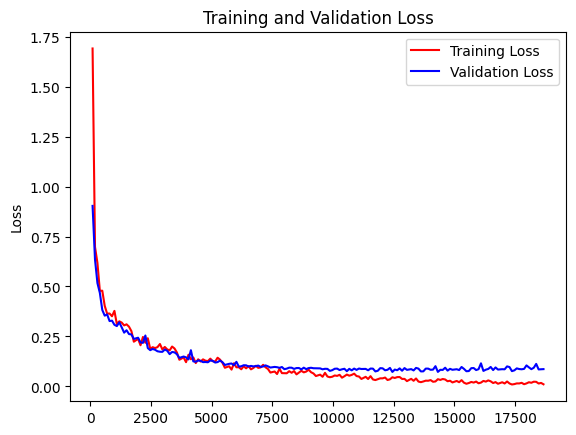

In [ ]:
plot_learning_curve(losses_FCN[0], losses_FCN[1], losses_FCN[2])

#### ❓ **Q 5.7.4 Explain which model is better and why. Use your learning curves as well as what you know about model capacity to explain your reasoning.** If you think your results do not reflect the best model, explain which you expect to be best and why.

The model that did the best seems to be the 5 layer network, since the accuracy of both the training and validation data seemed to do the best overall compared to the other architectures. It should be noted that the 2 layer network had less overfitting problems, but that is nullified by the better overall generalability from the 5 layer architecture.

#### ❓ **Q 5.7.5 Which model converges to a minimum faster? Why? What hyperparameters would you tune in order to get a model to converge faster?**

It seems that the 5 layer network converges onto the minimum faster than the other two. This can be explained due to the larger amount of layers, the model is able to train and escape local minimas more effeciently due to the higher amount of parameters and more diversified gradients.

#### ❓ **Q 5.7.6 Explain the purpose of the pooling layer**

The purpose of the pooling layer is to decrease the computational load when it is unneccessary to do the extra computation.

#### ❓ **Q 5.7.7  Is it possible for a model to have a smaller final loss, even if it has worse test accuracy.**

It is possible that a model could get a lower loss but yet have a worse test accuracy. This is primarily caused when the model is overfitted too much to the training data and can not accurately predict when given new data.

#### ❓ **Q 5.7.8 Explain the difference between the CNN models and FCN.**

FCN models have all input nodes connected to every single output nodes, while CNN don't necessarily have that. FCN are computationally heavier but are more generable.


---



### **5.8 Batch Normalization**

Choose the model that performs the best (`Net`, `Net2`, `Net5`, `FCN`). Add batch normalization layers where you see fit. Repeat and train and plot learning curves.



In [ ]:

# Define 5-Layer Network w/ batch normalization
class Net5(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net5,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2, stride = 1)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding = 2)
        self.fc1 = nn.Linear(14*14*64, 1024)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self,x):
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.pooling(out)
        out = self.conv2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = torch.flatten(out, start_dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ...

# Net5
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10
batch_size = 64
net = Net5(input_size, num_classes)
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_net5 = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)



Epoch [1/10], Step [100/1875], Train Loss: 1.2729, Val Loss: 0.4095
Epoch [1/10], Step [200/1875], Train Loss: 0.2984, Val Loss: 0.2826
Epoch [1/10], Step [300/1875], Train Loss: 0.2585, Val Loss: 0.2068
Epoch [1/10], Step [400/1875], Train Loss: 0.1930, Val Loss: 0.1915
Epoch [1/10], Step [500/1875], Train Loss: 0.1599, Val Loss: 0.1176
Epoch [1/10], Step [600/1875], Train Loss: 0.1155, Val Loss: 0.0855
Epoch [1/10], Step [700/1875], Train Loss: 0.1084, Val Loss: 0.1383
Epoch [1/10], Step [800/1875], Train Loss: 0.1030, Val Loss: 0.0848
Epoch [1/10], Step [900/1875], Train Loss: 0.1036, Val Loss: 0.0808
Epoch [1/10], Step [1000/1875], Train Loss: 0.0991, Val Loss: 0.0701
Epoch [1/10], Step [1100/1875], Train Loss: 0.0857, Val Loss: 0.0899
Epoch [1/10], Step [1200/1875], Train Loss: 0.0930, Val Loss: 0.0734
Epoch [1/10], Step [1300/1875], Train Loss: 0.0815, Val Loss: 0.0826
Epoch [1/10], Step [1400/1875], Train Loss: 0.0768, Val Loss: 0.0684
Epoch [1/10], Step [1500/1875], Train Loss:

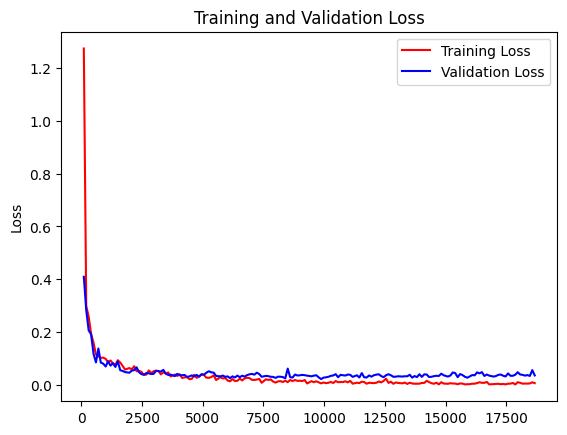

In [ ]:
plot_learning_curve(losses_net5[0], losses_net5[1], losses_net5[2])

#### ❓ **Q 5.8 Explain the purpose of the batch normalization layers,and how they affect training.**

The purpose of the batch normalization is to normalize the activation between each convolutional layer. This minimizes the chances for an exploding gradient problem and overall improves the performance of the model.

---
---

# End of Phase 1 😊🥳